In [1]:
import sys
sys.path.append('../src')  

from data_preprocessing import load_data, prepare_data
from model import LSTMModel
from train import train_model, validate
import torch
from torch.utils.data import TensorDataset, DataLoader
import pickle
import json

In [2]:
df = load_data('../data/household_power_consumption.txt')
(X_train, y_train), (X_val, y_val), (X_test, y_test), scaler = prepare_data(df)

c:\Users\MSI 1\Documents\Energy-Consumptiom\notebooks\../src\data_preprocessing.py:7: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(filepath,
c:\Users\MSI 1\Documents\Energy-Consumptiom\notebooks\../src\data_preprocessing.py:7: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(filepath,


In [3]:
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train)
X_val_tensor = torch.FloatTensor(X_val)
y_val_tensor = torch.FloatTensor(y_val)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_size=1, hidden_size=50, num_layers=1, output_size=1)

In [5]:
train_losses, val_losses = train_model(model, 
                                       train_loader, 
                                       val_loader, 
                                       num_epochs=20, 
                                       lr=0.001, 
                                       device=device)

Starting training...
Epoch 1/20 | Train Loss: 0.000853 | Val Loss: 0.000530
Epoch 2/20 | Train Loss: 0.000611 | Val Loss: 0.000582
Epoch 3/20 | Train Loss: 0.000600 | Val Loss: 0.000592
Epoch 4/20 | Train Loss: 0.000594 | Val Loss: 0.000582
Epoch 5/20 | Train Loss: 0.000592 | Val Loss: 0.000583
Epoch 6/20 | Train Loss: 0.000589 | Val Loss: 0.000586
Epoch 7/20 | Train Loss: 0.000586 | Val Loss: 0.000594
Epoch 8/20 | Train Loss: 0.000581 | Val Loss: 0.000598
Epoch 9/20 | Train Loss: 0.000575 | Val Loss: 0.000624
Epoch 10/20 | Train Loss: 0.000568 | Val Loss: 0.000645
Epoch 11/20 | Train Loss: 0.000559 | Val Loss: 0.000647
Epoch 12/20 | Train Loss: 0.000548 | Val Loss: 0.000606
Epoch 13/20 | Train Loss: 0.000542 | Val Loss: 0.000579
Epoch 14/20 | Train Loss: 0.000536 | Val Loss: 0.000557
Epoch 15/20 | Train Loss: 0.000530 | Val Loss: 0.000545
Epoch 16/20 | Train Loss: 0.000526 | Val Loss: 0.000539
Epoch 17/20 | Train Loss: 0.000523 | Val Loss: 0.000532
Epoch 18/20 | Train Loss: 0.000520 |

In [9]:
torch.save(model.state_dict(), '../models/lstm_energy_model.pth')
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Model and scaler saved!")


Model and scaler saved!



=== DIAGNOSTIC CHECKS ===

Mean hourly change: 0.0722 kW
Median hourly change: 0.0060 kW
Std of hourly changes: 0.2088 kW

Actual test variance: 0.7428
LSTM pred variance: 0.8310
Variance ratio: 1.12


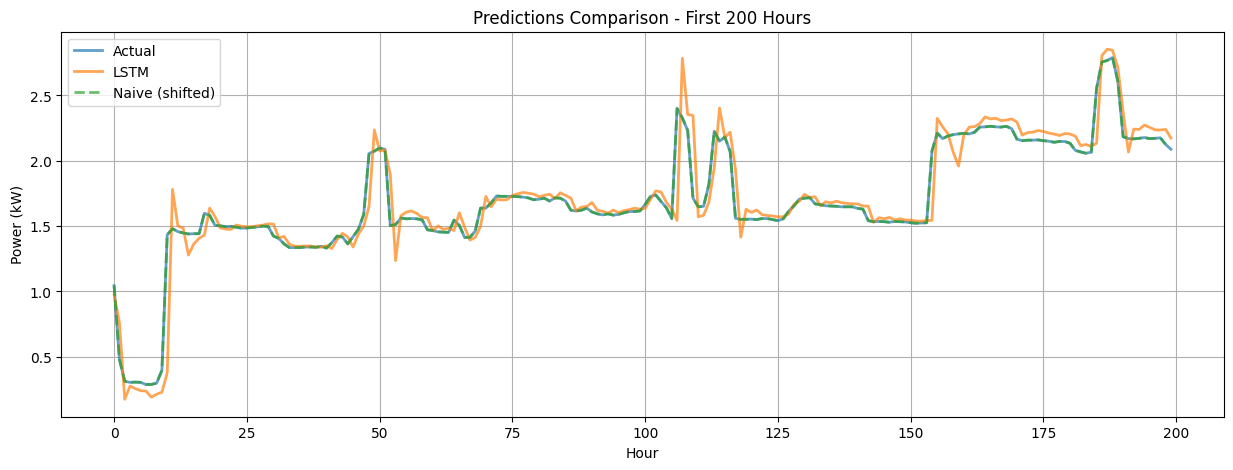


LSTM better than naive: 56106 / 307388 times (18.3%)
LSTM wins on: 56106 predictions
Naive wins on: 251282 predictions


In [8]:
import matplotlib.pyplot as plt

print("\n=== DIAGNOSTIC CHECKS ===\n")

# 1. Hour-to-hour volatility
y_test_kw = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
hourly_changes = np.abs(y_test_kw[1:] - y_test_kw[:-1])
print(f"Mean hourly change: {hourly_changes.mean():.4f} kW")
print(f"Median hourly change: {np.median(hourly_changes):.4f} kW")
print(f"Std of hourly changes: {hourly_changes.std():.4f} kW")

# 2. Prediction variance
test_predictions_kw = scaler.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
print(f"\nActual test variance: {y_test_kw.var():.4f}")
print(f"LSTM pred variance: {test_predictions_kw.var():.4f}")
print(f"Variance ratio: {test_predictions_kw.var() / y_test_kw.var():.2f}")

# 3. Visualize a sample
plt.figure(figsize=(15, 5))
sample_size = 200
plt.plot(y_test_kw[:sample_size], label='Actual', alpha=0.7, linewidth=2)
plt.plot(test_predictions_kw[:sample_size], label='LSTM', alpha=0.7, linewidth=2)
plt.plot(y_test_kw[:sample_size-1], label='Naive (shifted)', alpha=0.7, linewidth=2, linestyle='--')
plt.xlabel('Hour')
plt.ylabel('Power (kW)')
plt.title('Predictions Comparison - First 200 Hours')
plt.legend()
plt.grid(True)
plt.show()

# 4. Where does LSTM do better/worse than naive?
lstm_errors = np.abs(y_test_kw[1:] - test_predictions_kw[1:])
naive_errors = np.abs(y_test_kw[1:] - y_test_kw[:-1])

lstm_better = lstm_errors < naive_errors
print(f"\nLSTM better than naive: {lstm_better.sum()} / {len(lstm_better)} times ({lstm_better.mean()*100:.1f}%)")
print(f"LSTM wins on: {lstm_better.sum()} predictions")
print(f"Naive wins on: {(~lstm_better).sum()} predictions")
